In [2]:
import logging

import matplotlib.pyplot as plt
import networkx as nx
import pymimir as mi
import torch
import torch_geometric as pyg

from rgnet.encoding import ColorGraphEncoder
from rgnet.pddl_import import import_all_from, import_problems
from rgnet.supervised.data import MultiInstanceSupervisedSet

In [3]:
logging.getLogger().setLevel(logging.INFO)

In [4]:
domain = mi.DomainParser("test/pddl_instances/blocks/domain.pddl").parse()
problem = mi.ProblemParser("test/pddl_instances/blocks/problem.pddl").parse(domain)
state_space = mi.StateSpace.new(problem, mi.GroundedSuccessorGenerator(problem))
state = state_space.get_initial_state()
graph = ColorGraphEncoder(domain).encode(state)

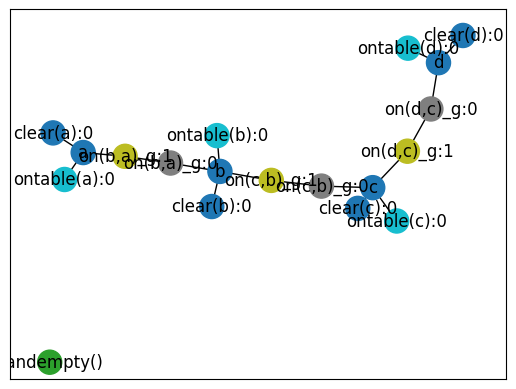

In [5]:
nx.draw_networkx(
    graph,
    with_labels=True,
    labels={n: str(n) for n in graph.nodes},
    nodelist=[n for n in graph.nodes],
    node_color=[attr["color"] for _, attr in graph.nodes.data()],
    cmap="tab10",
)

In [6]:
# In the from_networkx the graph is converted to a DiGraph. In the process it has to be pickled, which is not possible for pymimir.State
del graph.graph['state']
# Every node has to have the same features in order to be converted to y tensor
for node, attr in graph.nodes.data():
    if "info" in attr:
        del attr["info"]

In [7]:
data = pyg.utils.from_networkx(graph)
data

Data(edge_index=[2, 34], color=[19], num_nodes=19)

In [8]:
data.x = data['color'].float()  # the GCNLayer requires float-features

In [9]:
data.x

tensor([ 0.,  0.,  0.,  0.,  1.,  1.,  1.,  1., 16., 16., 16., 16.,  4., 12.,
        13., 12., 13., 12., 13.])

In [10]:
from rgnet.model import PureGNN

In [11]:
model = PureGNN(in_channel=1, embedding_size=32, num_layer=4)
model.train()
out = model(data.x, data.edge_index,
            batch=torch.zeros(data.x.shape[0],
                              dtype=torch.int64))  # batch assigns nodes to graphs

In [12]:
out

tensor([0.1188], grad_fn=<ViewBackward0>)

In [ ]:
domain, problems = import_all_from("data/pddl_domains/blocks")
problems

In [ ]:
train_set = MultiInstanceSupervisedSet(problems, ColorGraphEncoder(domain),
                                       root="data/datasets/blocks/train", log=True)

In [ ]:
train_set.x.shape, len(train_set)

In [ ]:
eval_problems = import_problems("data/pddl_domains/blocks/eval", domain)
eval_problems

In [ ]:
eval_set = MultiInstanceSupervisedSet(eval_problems, ColorGraphEncoder(domain),
                                      root="data/datasets/blocks/eval", log=True)

In [ ]:
eval_set.len()

In [ ]:
# Assuming 'train_set.y' is your tensor containing labels
label_distribution = train_set.get_label_distribution()

# Plot histogram
plt.bar(torch.arange(len(label_distribution)), label_distribution)

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution Histogram')

# Show plot
plt.show()

In [ ]:
train_set.print_summary()

In [ ]:
print("Standard deviation and mean of labels:", torch.std_mean(train_set.y))